In [50]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ontime = pd.concat([pd.read_csv(f) for f in glob.glob("./data/T_ONTIME_*.csv")], ignore_index=True)

/Users/matusbitara/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/matusbitara/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [3]:
df_ontime.shape

(16608283, 42)

In [4]:
df_ontime.columns

Index(['ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'ARR_DELAY', 'ARR_TIME',
       'BRANDED_CODE_SHARE', 'CANCELLATION_CODE', 'CANCELLED', 'CARRIER_DELAY',
       'CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DEP_DELAY',
       'DEP_TIME', 'DEST', 'DEST_AIRPORT_ID', 'DEST_CITY_NAME', 'DISTANCE',
       'DIVERTED', 'DUP', 'FIRST_DEP_TIME', 'FLIGHTS', 'FL_DATE',
       'LATE_AIRCRAFT_DELAY', 'LONGEST_ADD_GTIME', 'MKT_CARRIER',
       'MKT_CARRIER_FL_NUM', 'MKT_UNIQUE_CARRIER', 'NAS_DELAY',
       'OP_CARRIER_FL_NUM', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_CITY_NAME', 'SECURITY_DELAY', 'TAIL_NUM', 'TAXI_IN', 'TAXI_OUT',
       'TOTAL_ADD_GTIME', 'Unnamed: 41', 'WEATHER_DELAY', 'WHEELS_OFF',
       'WHEELS_ON'],
      dtype='object')

In [5]:
df_ontime.head(3)

,ACTUAL_ELAPSED_TIME,AIR_TIME,ARR_DELAY,ARR_TIME,BRANDED_CODE_SHARE,CANCELLATION_CODE,CANCELLED,CARRIER_DELAY,CRS_ARR_TIME,CRS_DEP_TIME,...,ORIGIN_CITY_NAME,SECURITY_DELAY,TAIL_NUM,TAXI_IN,TAXI_OUT,TOTAL_ADD_GTIME,Unnamed: 41,WEATHER_DELAY,WHEELS_OFF,WHEELS_ON
0,413.0,386.0,39.0,1125.0,B6,NaN,0.0,0.0,1046,736,...,"New York, NY",0.0,N779JB,4.0,23.0,NaN,NaN,0.0,755.0,1121.0
1,304.0,279.0,65.0,1207.0,B6,NaN,0.0,31.0,1102,732,...,"Boston, MA",0.0,N648JB,10.0,15.0,NaN,NaN,0.0,818.0,1157.0
2,131.0,82.0,21.0,1222.0,B6,NaN,0.0,0.0,1201,1011,...,"Charlotte, NC",0.0,N296JB,2.0,47.0,NaN,NaN,0.0,1058.0,1220.0


In [6]:
df_ontime.FL_DATE = pd.to_datetime(df_ontime.FL_DATE, dayfirst=True)

### mean and median of arrival delay

In [7]:
# mean and median
print(df_ontime.ARR_DELAY.mean())
print(df_ontime.ARR_DELAY.median())

5.208620378901379
-6.0


### distribution of arrival delay

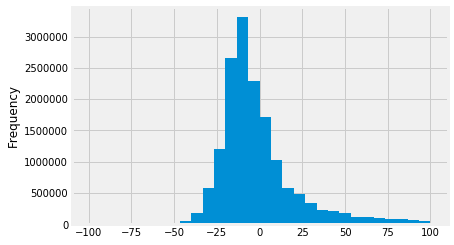

In [9]:
df_ontime.ARR_DELAY.plot(kind='hist',bins=30,range=(-100,100))
plt.show()

###  mark outliers (based on IQR) from arrival delays

In [11]:
def IQR_outliers(series):
    Q1 = series.quantile(q=0.25)
    Q3 = series.quantile(q=0.75)
    IQR = Q3 - Q1
    
    lower_threshold = Q1 - 1.5*IQR
    upper_threshold = Q3 + 1.5*IQR
    
    return lower_threshold, upper_threshold

l,u = IQR_outliers(df_ontime.ARR_DELAY)

# create column outlier
df_ontime['ARR_DELAY_OUTLIER'] = df_ontime['ARR_DELAY'].apply(lambda x: True if x<l or x>u else False)

### plot arrival delay distribution without outliers

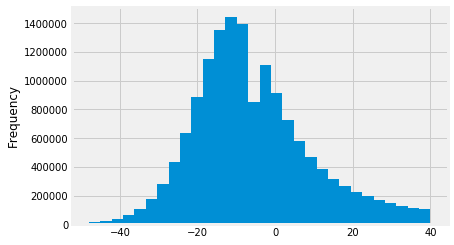

In [12]:
# plot distribution without outliers
df_ontime[df_ontime.ARR_DELAY_OUTLIER ==False].ARR_DELAY.plot(kind='hist',bins=30)
plt.show()

### Are arrival delays greater in weekends?

In [13]:
df_ontime['IS_WEEKEND'] = df_ontime['FL_DATE'].apply(lambda d: True if d.weekday() > 4 else False)

In [14]:
print(df_ontime[df_ontime.IS_WEEKEND ==True].ARR_DELAY.mean())
print(df_ontime[df_ontime.IS_WEEKEND ==False].ARR_DELAY.mean())

3.9396185445421086
5.6630581182779585


/Users/matusbitara/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/matusbitara/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


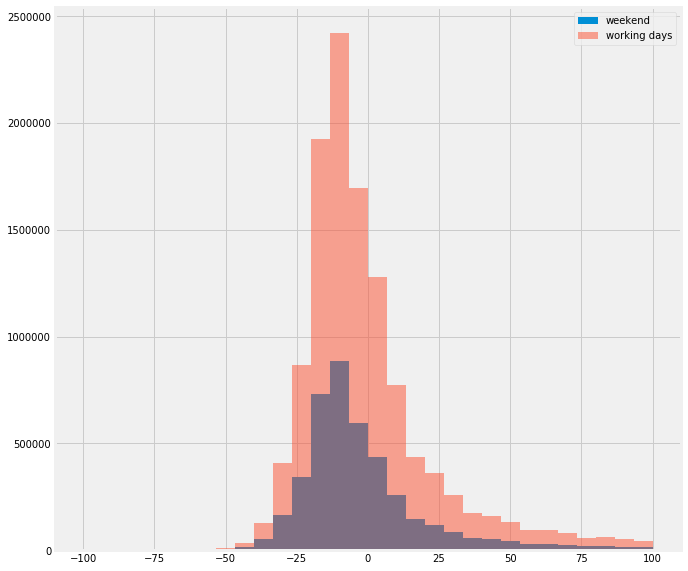

In [15]:
# delays in weekends
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(df_ontime[df_ontime.IS_WEEKEND ==True].ARR_DELAY,bins=30,range=(-100,100),alpha=1)
ax.hist(df_ontime[df_ontime.IS_WEEKEND ==False].ARR_DELAY,bins=30,range=(-100,100),alpha=0.5)
ax.legend(['weekend','working days'])
plt.show()

### Are arrival delays changing during year?

In [16]:
df_ontime['YEAR_MONTH'] = df_ontime.FL_DATE.dt.strftime('%Y-%m')

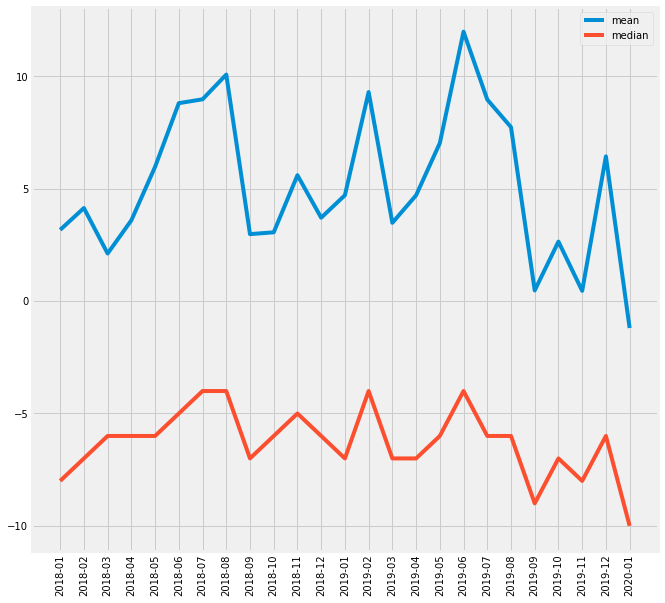

In [17]:
# delay by month
month_median_delay = df_ontime.groupby('YEAR_MONTH')['ARR_DELAY'].median()
month_mean_delay = df_ontime.groupby('YEAR_MONTH')['ARR_DELAY'].mean()

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(month_mean_delay.index,month_mean_delay,label='mean')
ax.plot(month_median_delay.index,month_median_delay,label='median')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### Are arrival delays changed in 2019 compare to 2018 in same months?

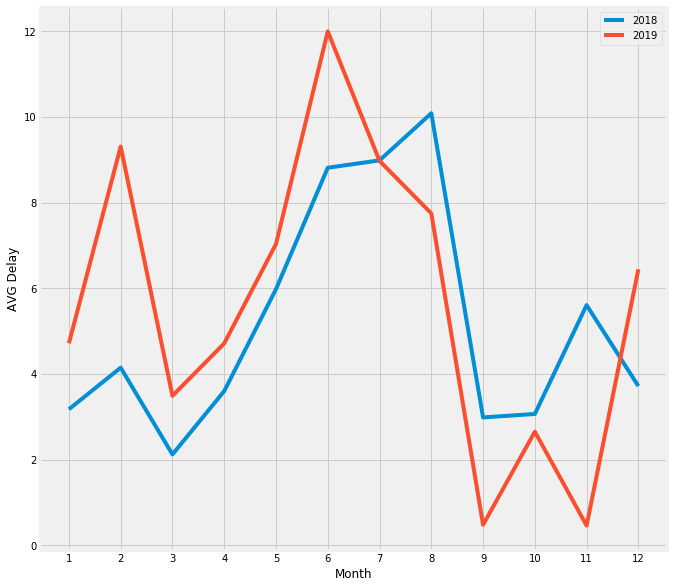

In [18]:
# delay by year
fig, ax = plt.subplots(figsize=(10,10))
avg_delay_2018 = month_mean_delay[month_mean_delay.index.str.contains('2018')]
avg_delay_2019 = month_mean_delay[month_mean_delay.index.str.contains('2019')]
months = np.arange(1,13)

ax.plot(months, avg_delay_2018,label='2018')
ax.plot(months, avg_delay_2019,label='2019')
plt.legend()
plt.xlabel('Month')
plt.ylabel('AVG Delay')
plt.xticks(months)
plt.show()

In [19]:
# are average delays between years correlated?
np.corrcoef(avg_delay_2018,avg_delay_2019)

array([[1.        , 0.63334745],
       [0.63334745, 1.        ]])

### Are arrival delays in summer caused by traffic?

In [20]:
flight_month = df_ontime.YEAR_MONTH.value_counts().to_frame('TOTAL_FLIGHTS').sort_index()

np.corrcoef(flight_month['TOTAL_FLIGHTS'], month_mean_delay)

array([[1.        , 0.31243424],
       [0.31243424, 1.        ]])

### Are arrival delays caused by departure delays?

In [21]:
np.corrcoef(df_ontime['ARR_DELAY'].fillna(0),df_ontime['DEP_DELAY'].fillna(0))

array([[1.        , 0.95597742],
       [0.95597742, 1.        ]])

### Which airports have the biggest departure delays?

In [22]:
df_delays = df_ontime.groupby('ORIGIN_CITY_NAME')[['ARR_DELAY','DEP_DELAY']].mean()\
                     .assign(DELAY_DIFF = lambda x: x['DEP_DELAY'] - x['ARR_DELAY'])\
                     .sort_values('DELAY_DIFF',ascending=False)
df_delays.head()

,ARR_DELAY,DEP_DELAY,DELAY_DIFF
ORIGIN_CITY_NAME,,,
"Unalaska, AK",8.157816,22.464925,14.307109
"Rhinelander, WI",0.633163,9.870844,9.237681
"New York, NY",4.289957,12.783873,8.493916
"Del Rio, TX",0.302961,8.370621,8.067660
"Pierre, SD",5.494876,13.150365,7.655489


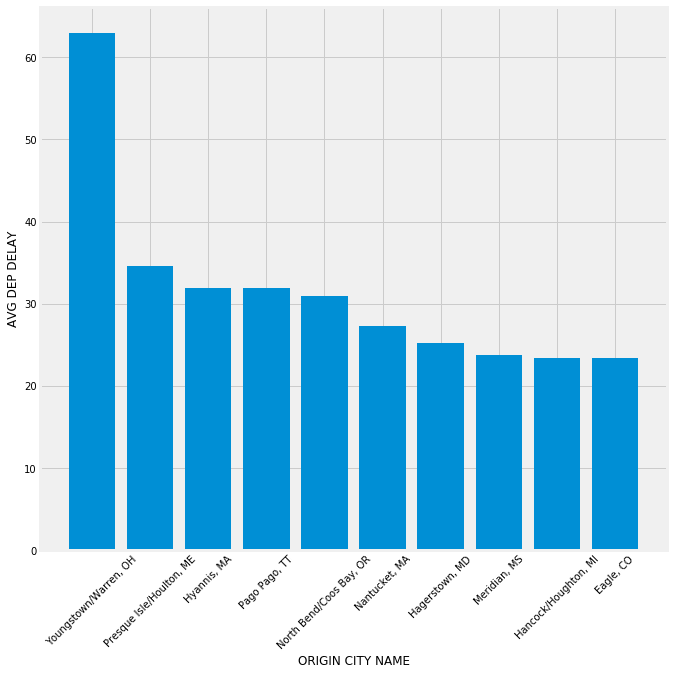

In [23]:
# top 10 airports with the biggest departure delays
fix,ax = plt.subplots(figsize=(10,10))
df_dep_delays = df_delays['DEP_DELAY'].sort_values(ascending=False)

top_n = 10
ax.bar(df_dep_delays.head(top_n).index,df_dep_delays.head(top_n).values)
plt.xticks(rotation=45)
plt.xlabel('ORIGIN CITY NAME')
plt.ylabel('AVG DEP DELAY')
plt.show()

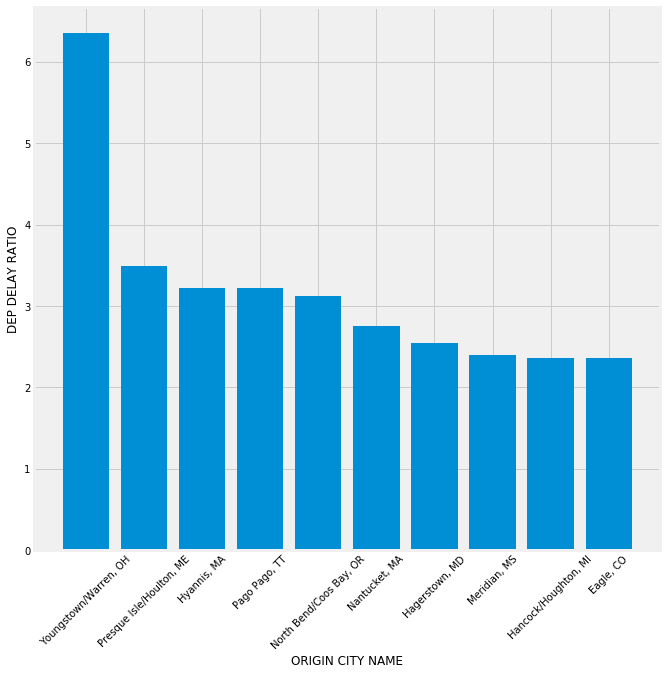

In [24]:
# comparing departure delays to average departure delay
fix,ax = plt.subplots(figsize=(10,10))
df_dep_delays_ratio = df_dep_delays.divide(df_delays['DEP_DELAY'].mean())
ax.bar(df_dep_delays_ratio.head(top_n).index,df_dep_delays_ratio.head(top_n).values)
plt.xticks(rotation=45)
plt.xlabel('ORIGIN CITY NAME')
plt.ylabel('DEP DELAY RATIO')
plt.show()

### Find the most bussiest airports

In [25]:
# total TRAFFIC per city + ratio of US TRAFFIC
df_total_TRAFFIC = pd.concat([df_ontime['ORIGIN_CITY_NAME'].value_counts(), 
                             df_ontime['DEST_CITY_NAME'].value_counts()],
                             axis=1,
                             sort=True)\
                    .reset_index()\
                    .rename(columns= {'index': 'CITY_NAME',
                                      'ORIGIN_CITY_NAME': "COUNT_DEPARTURES",
                                      'DEST_CITY_NAME': "COUNT_ARRIVALS"})\
                    .assign(TOTAL_TRAFFIC = lambda x: x['COUNT_DEPARTURES'] + x['COUNT_ARRIVALS'],
                            TRAFFIC_RATIO = lambda x: x['TOTAL_TRAFFIC'] / x['TOTAL_TRAFFIC'].sum())\
                    .sort_values('TOTAL_TRAFFIC', ascending=False)\
    

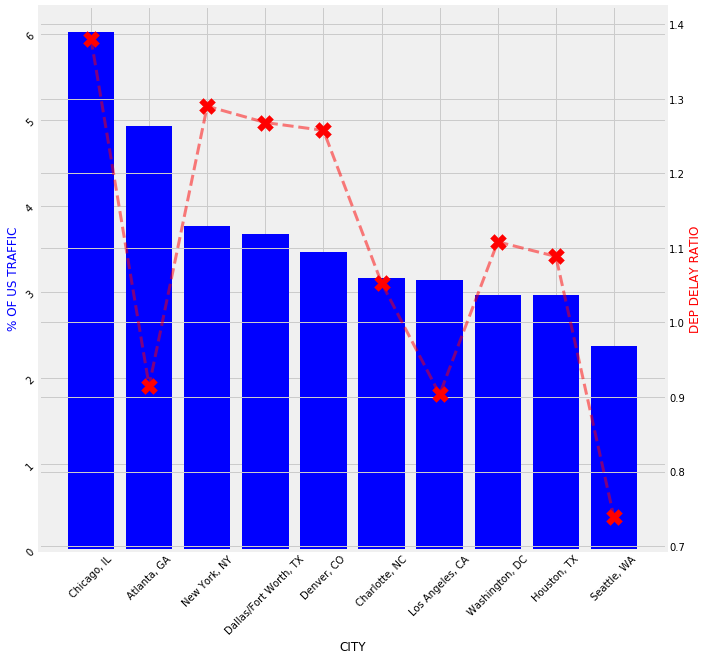

In [26]:
# top 10 airports bussiest airports together with their delay ratio
fix,ax = plt.subplots(figsize=(10,10))
x = df_total_TRAFFIC.head(top_n).CITY_NAME
y = df_total_TRAFFIC.head(top_n).TRAFFIC_RATIO*100

ax.bar(x,y,color='blue')
ax.set_xlabel('CITY')
ax.set_ylabel('% OF US TRAFFIC',color='blue')
ax.tick_params(rotation=45)

ax2 = ax.twinx()  

ax2.set_ylabel('DEP DELAY RATIO',color='red')
ax2.plot(x, df_dep_delays_ratio[x],color='red',linestyle='--',alpha=0.5,linewidth=3)
ax2.scatter(x, df_dep_delays_ratio[x],color='red', marker="X",s=250)

fig.tight_layout()
plt.show()

### How manny states cover 50% of US air traffic? 

In [27]:
# TRAFFIC by states
df_total_TRAFFIC['STATE'] = df_total_TRAFFIC['CITY_NAME'].apply(lambda x: x.split(',')[-1])

df_state_TRAFFIC = df_total_TRAFFIC.groupby('STATE')[['TRAFFIC_RATIO']].sum()\
                                 .sort_values(by ='TRAFFIC_RATIO', ascending=False)\
                                 .reset_index()\
                                 .assign(CUMSUM_RATIO = lambda x: x['TRAFFIC_RATIO'].cumsum())
df_state_TRAFFIC['STATE_RANK'] = [f'{i} {s}' for i,s in enumerate(df_state_TRAFFIC.STATE)]

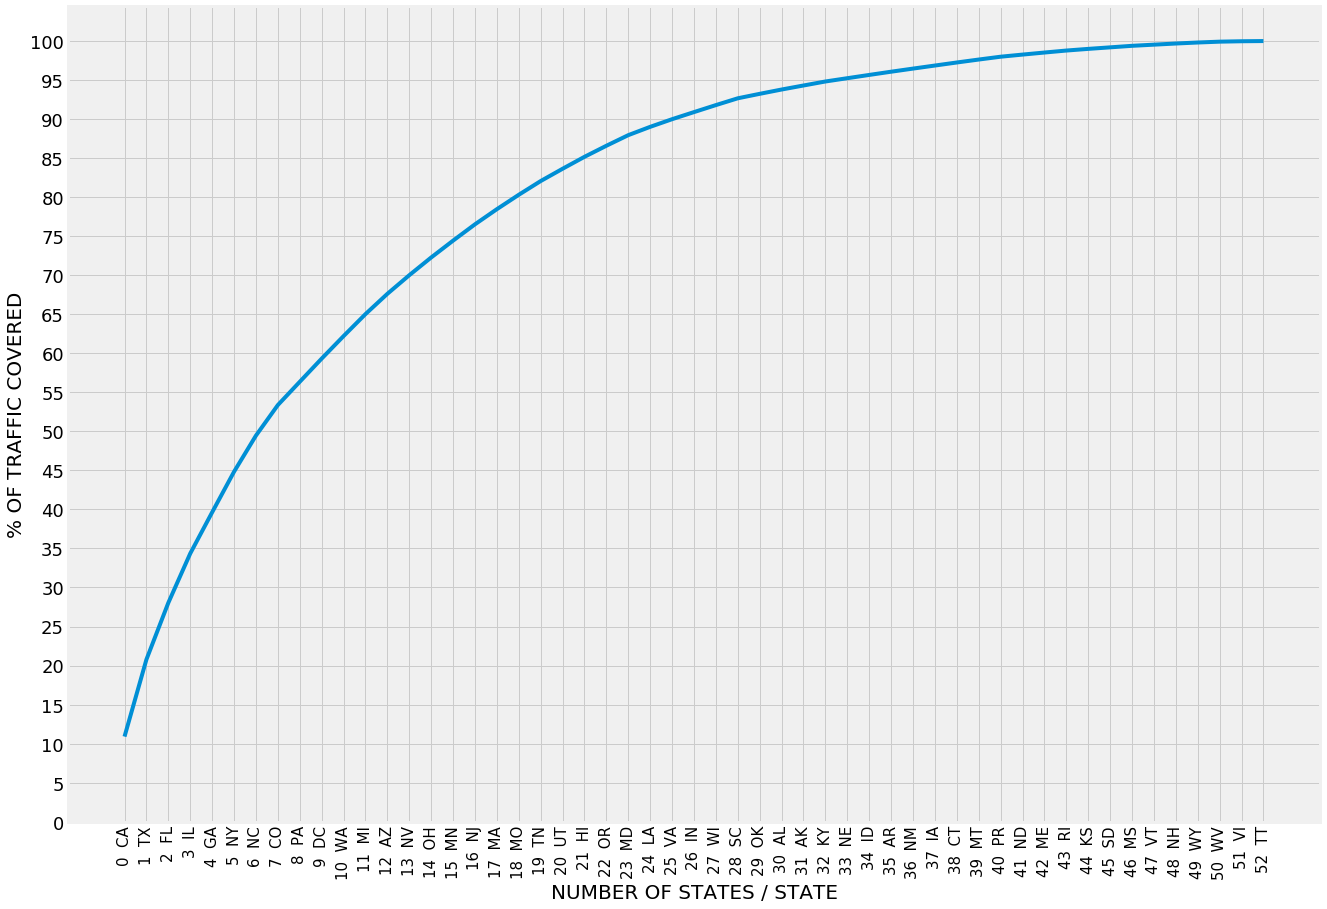

In [28]:
fix, ax = plt.subplots(figsize=(20,15))
ax = plt.plot(df_state_TRAFFIC.STATE_RANK,df_state_TRAFFIC.CUMSUM_RATIO*100)
plt.xlabel('NUMBER OF STATES / STATE',fontsize=20)
plt.ylabel('% OF TRAFFIC COVERED',fontsize=20)
plt.yticks(np.arange(0,101,5),fontsize=18)
plt.xticks(rotation=90,fontsize=15)
plt.show()

### What caused delays in different months? 

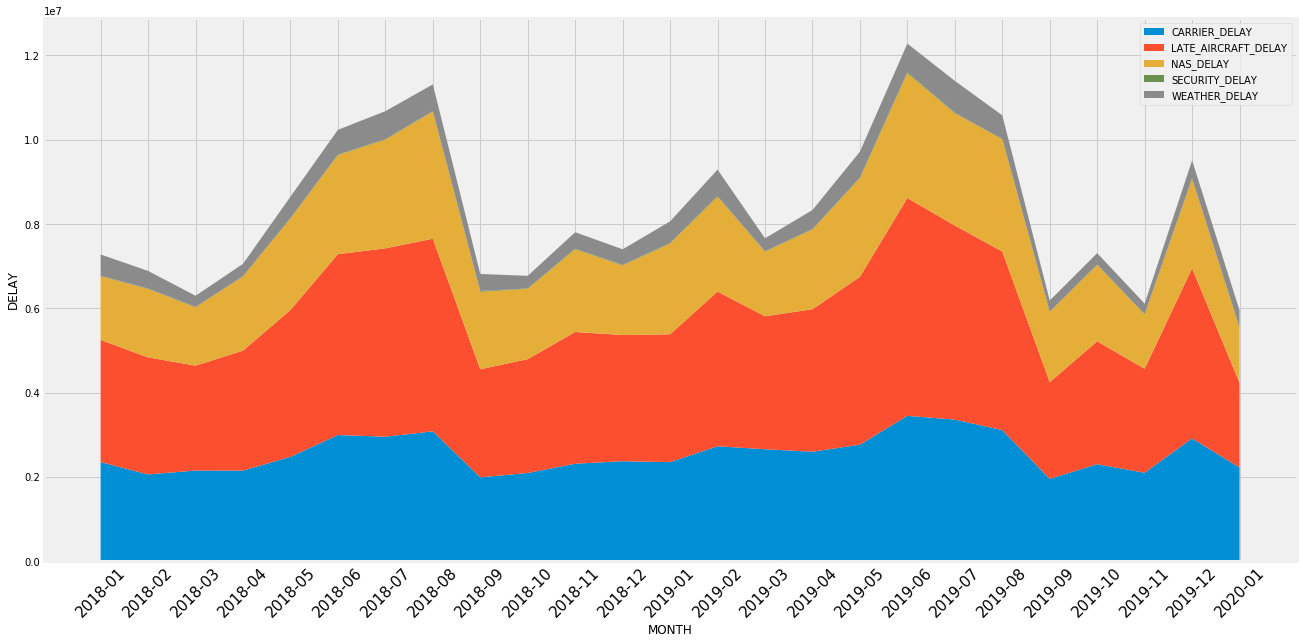

In [29]:
delay_cols = [
 'ARR_DELAY',
 'CARRIER_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'WEATHER_DELAY']

df_caused_delays = df_ontime[delay_cols+['YEAR_MONTH']].fillna(0).query('ARR_DELAY != 0')
df_caused_delays = df_caused_delays.drop('ARR_DELAY',axis=1).groupby('YEAR_MONTH').sum()

fig, ax = plt.subplots(figsize=(20,10))
ax.stackplot(df_caused_delays.index,df_caused_delays.values.transpose(),labels=df_caused_delays.columns)
plt.xticks(rotation=45,fontsize=15)
plt.xlabel('MONTH')
plt.ylabel('DELAY')
plt.legend()
plt.show()

### What caused delays in general? 

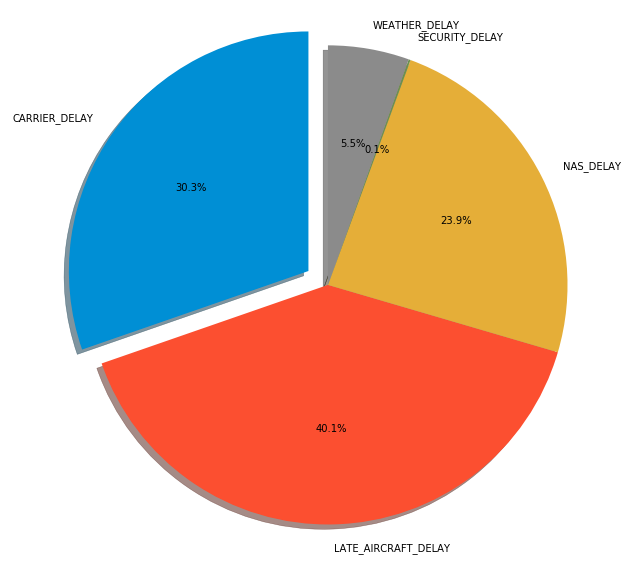

In [30]:
delays_pie_data = df_caused_delays.sum()

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(delays_pie_data, explode = (0.1, 0.0, 0, 0,0), labels=delays_pie_data.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal') 

plt.show()

### In what time (hour) most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [32]:
df_air_time = df_ontime[['DEP_TIME', 'AIR_TIME','ARR_DELAY','DEP_DELAY']].query('AIR_TIME > 0').dropna()
df_air_time['FLIGHT_TYPE'] = pd.qcut(df_air_time['AIR_TIME'], q=[0,.33, .66, 1], labels=['SHORT','MEDIUM','LONG'])
df_air_time['DEP_HOUR'] = df_air_time['DEP_TIME'].astype('str').apply(lambda x: 0 if x[:-4] in ['', '24'] else int(x[:-4]))

In [33]:
df_flight_type_pivot = pd.DataFrame(df_air_time.pivot_table(index='DEP_HOUR',
                                               columns='FLIGHT_TYPE',
                                               values='ARR_DELAY', 
                                               aggfunc='count')\
                                  .to_records())

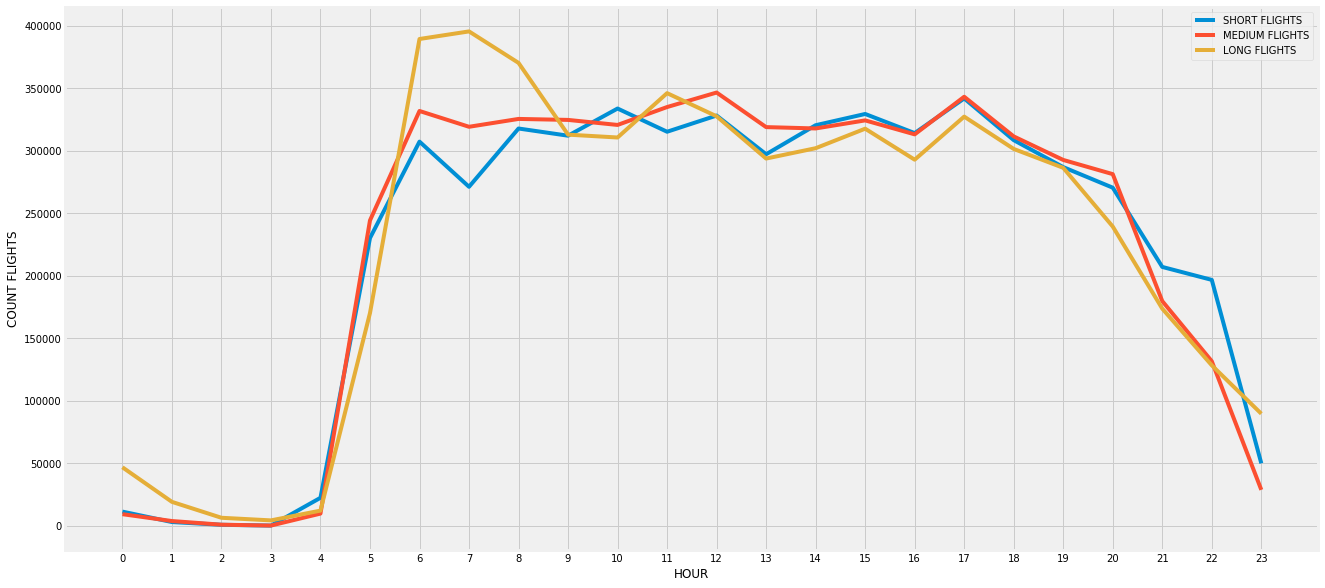

In [34]:
fix,axes = plt.subplots(figsize=(20,10))
ax = plt.plot(df_flight_type_pivot.DEP_HOUR,df_flight_type_pivot.SHORT,label='SHORT FLIGHTS')
ax2 = plt.plot(df_flight_type_pivot.DEP_HOUR,df_flight_type_pivot.MEDIUM,label= 'MEDIUM FLIGHTS')
ax3 = plt.plot(df_flight_type_pivot.DEP_HOUR,df_flight_type_pivot.LONG, label='LONG FLIGHTS')
plt.legend()
plt.xticks(df_flight_type_pivot.DEP_HOUR)
plt.xlabel('HOUR')
plt.ylabel('COUNT FLIGHTS')
plt.show()

In [35]:
# Are there any differences in delays for different flight types?
df_air_time.groupby('FLIGHT_TYPE')[['DEP_DELAY','ARR_DELAY']].mean()

,DEP_DELAY,ARR_DELAY
FLIGHT_TYPE,,
SHORT,9.360288,4.594664
MEDIUM,10.563968,5.581919
LONG,10.989766,5.446995


### Are longer flights operated by faster planes?

In [42]:
df_speed = df_ontime[['ACTUAL_ELAPSED_TIME','DISTANCE']]

In [43]:
# Is ACTUAL_ELAPSED_TIME corelated with DISTANCE?
df_speed.corr()

,ACTUAL_ELAPSED_TIME,DISTANCE
ACTUAL_ELAPSED_TIME,1.000000,0.967703
DISTANCE,0.967703,1.000000


In [51]:
df_speed['VELOCITY (MPH)'] =  df_speed['DISTANCE'] / (df_speed['ACTUAL_ELAPSED_TIME'] / 60)
df_speed['DISTANCE_CATEGORY'] = pd.qcut(df_speed['DISTANCE'], q=[0,.33, .66, 1])
df_speed_grouped = df_speed.groupby('DISTANCE_CATEGORY')[['VELOCITY (MPH)']].mean().reset_index()

In [52]:
df_speed_grouped = df_speed.groupby('DISTANCE_CATEGORY')[['VELOCITY (MPH)']].mean().reset_index()
df_speed_grouped['DISTANCE_CATEGORY'] = df_speed_grouped['DISTANCE_CATEGORY'].astype(str)

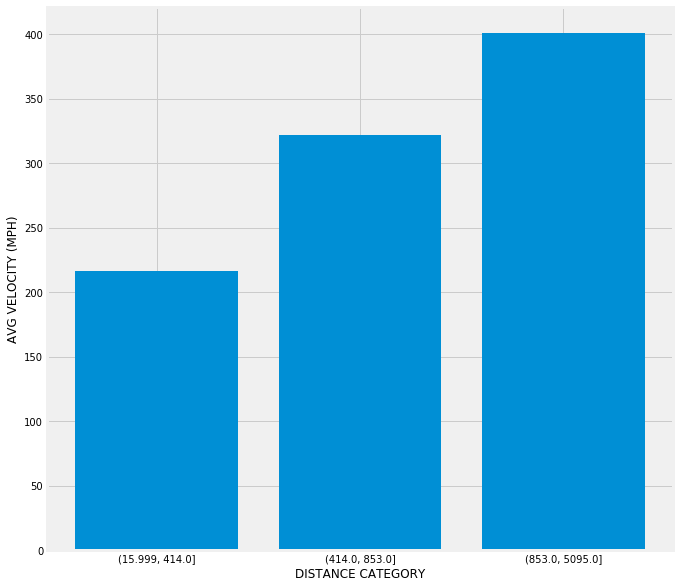

In [53]:
fix,ax = plt.subplots(figsize=(10,10))
ax.bar(df_speed_grouped['DISTANCE_CATEGORY'],df_speed_grouped['VELOCITY (MPH)'])
plt.xlabel('DISTANCE CATEGORY')
plt.ylabel('AVG VELOCITY (MPH)')
plt.show()